#Εργασία 2 Τεχνικές Εξόρυξης Δεδομένων 2020-2021
sdi1300175 Ηλίας Τζιώτης 

Η εργασία αυτή είναι ατομική όπως και η προηγούμενη.

#Session Start
Importing libraries and csv

In [3]:
import os
import pandas as pd
import datetime as dt
from string import punctuation
import matplotlib.pyplot as plt
import nltk
import re
import gensim
import numpy as np
import io

In [2]:

from google.colab import files
print("Please upload Fake.csv")
data_to_load = files.upload()
pd.read_csv(io.BytesIO(data_to_load['Fake.csv']))
print("Please upload True.csv")
data_to_load = files.upload()
pd.read_csv(io.BytesIO(data_to_load['True.csv']))

Please upload Fake.csv


Saving Fake.csv to Fake.csv
Please upload True.csv


Saving True.csv to True.csv


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


Ξεχωρίζω τα fake με τα true news και τα ενώνω σε ένα.

In [19]:
def GetData():
    df_l = []
    
    for i in ('Fake.csv','True.csv'):
        file = pd.read_csv(f'{i}')
        file['label'] = i[0:4]
        df_l.append(file)
    
    file = pd.concat(df_l)
    
    return file

data = GetData()

In [20]:
data.head(10)

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Fake
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",Fake
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017",Fake
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017",Fake
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017",Fake
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017",Fake


#1: Προεπεξεργασία/Καθάρισμα

Τσεκάρω για '' , ' ' και NULL

In [21]:
data.isnull().sum()
data[data['text'].isin(['', ' '])]
data['final_text'] = data['title'] + " " + data['text']
data

,title,text,subject,date,label,final_text
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake,Donald Trump Sends Out Embarrassing New Year’...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake,Drunk Bragging Trump Staffer Started Russian ...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake,Sheriff David Clarke Becomes An Internet Joke...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Fake,Trump Is So Obsessed He Even Has Obama’s Name...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Fake,Pope Francis Just Called Out Donald Trump Dur...
...,...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",True,'Fully committed' NATO backs new U.S. approach...
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",True,LexisNexis withdrew two products from Chinese ...
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",True,Minsk cultural hub becomes haven from authorit...
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",True,Vatican upbeat on possibility of Pope Francis ...


#2: Μελέτη των δεδομένων

In [32]:
# Calculate the number of words in a string

def Words(string):
    if len(string) == 0:
        return 0
    
    return string.count(' ') + 1


# Calculate total number of unique words
def UniqueWords(string):
    a = {}
    for j in string.lower().split(' '):
        if j not in a:
            a[j] = 1
    return len(a)


# Calculate the average word length of a given string
def AvgLength(string):
    if len(string) == 0:
        return 0
    
    tot_length = Words(string)
    letters = len(string) - tot_length + 1
    
    return letters/tot_length


# Calcualte number of uppercase words in a string
def UpperCaseWords(string):
    words = string.split()   
    return len([word for word in words if word.isupper()])


# Calculate total number of punctuation characters used
punctuationSet = set(punctuation)
def Punctuations(string):
    return sum([1 for s in string if s in punctuationSet])

Αφαιρώ url και stopwords από το αρχείο

In [23]:
nltk.download('stopwords')
# Remove urls from text    
def RemoveUrls(string):
    return re.sub('https\S+','', string)

# Removing stopwords .
stop_words = set(nltk.corpus.stopwords.words('english'))
stop_words.update(punctuationSet)

# This tokenizer allows us to only extract words from a given string and ignore any punctuation used
tokenizer_for_words = nltk.tokenize.RegexpTokenizer(r'\w+')

def RemoveStopWordsAndPunctuation(string):
    output = []
    words = tokenizer_for_words.tokenize(string)
    for word in words:
        if word.strip().lower() not in stop_words and len(word) > 1:
            output.append(word)
    
    return ' '.join(output)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Βρίσκω πόσα είναι

In [27]:
data['number_of_punctuations'] = data['final_text'].apply(Punctuations)

# Remove stop words and punctuation before other functions
data['final_text'] = data['final_text'].apply(RemoveUrls)
data['final_text'] = data['final_text'].apply(RemoveStopWordsAndPunctuation)

In [35]:
# Gather additional data from text
data['number_of_words'] = data['final_text'].apply(Words)
data['avg_number_of_words'] = data['final_text'].apply(AvgLength)
data['number_of_unique_words'] = data['final_text'].apply(UniqueWords)
data['number_of_uppercase_words'] = data['final_text'].apply(UpperCaseWords)
data['number_of_lowercase_words'] = data['number_of_words'] - data['number_of_uppercase_words']
# Make final_text all lower case
data['final_text'] = data['final_text'].str.lower()

In [36]:
print("Deploying some stats")
data.head(5)

Deploying some stats


,title,text,subject,date,label,final_text,number_of_punctuations,number_of_words,avg_number_of_words,number_of_unique_words,number_of_uppercase_words,number_of_lowercase_words
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake,donald trump sends embarrassing new year eve m...,0,302,5.798013,178,0,302
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake,drunk bragging trump staffer started russian c...,0,191,6.575916,145,0,191
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake,sheriff david clarke becomes internet joke thr...,2,369,5.997290,237,0,369
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Fake,trump obsessed even obama name coded website i...,5,285,5.887719,187,0,285
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Fake,pope francis called donald trump christmas spe...,0,219,5.922374,164,0,219


In [37]:
stats = data.describe().round(1)
stats

,number_of_punctuations,number_of_words,avg_number_of_words,number_of_unique_words,number_of_uppercase_words,number_of_lowercase_words
count,44898.0,44898.0,44898.0,44898.0,44898.0,44898.0
mean,0.1,245.6,6.3,168.1,0.0,245.6
std,1.1,207.2,0.4,118.7,0.0,207.2
min,0.0,0.0,0.0,1.0,0.0,0.0
25%,0.0,130.0,6.1,96.0,0.0,130.0
50%,0.0,218.0,6.3,156.0,0.0,218.0
75%,0.0,306.0,6.6,212.0,0.0,306.0
max,85.0,5066.0,18.7,2335.0,0.0,5066.0


Aφαιρώ τα datapoint χωρίς καμία λέξη

In [38]:
data = data[data['number_of_words'] > 0]
data_desc = data.describe().round(1)
data_desc

,number_of_punctuations,number_of_words,avg_number_of_words,number_of_unique_words,number_of_uppercase_words,number_of_lowercase_words
count,44889.0,44889.0,44889.0,44889.0,44889.0,44889.0
mean,0.1,245.6,6.3,168.1,0.0,245.6
std,1.1,207.2,0.4,118.7,0.0,207.2
min,0.0,4.0,4.3,4.0,0.0,4.0
25%,0.0,130.0,6.1,96.0,0.0,130.0
50%,0.0,218.0,6.3,156.0,0.0,218.0
75%,0.0,306.0,6.6,212.0,0.0,306.0
max,85.0,5066.0,18.7,2335.0,0.0,5066.0


Θα χρησιμοποιήσω ένα subset των δεδομένων με 2000 λέξεις,για να κάνω καλύτερο πλοτ

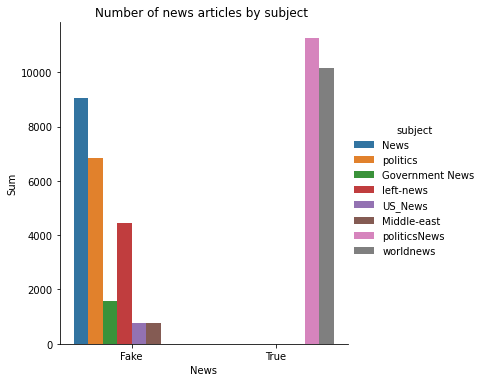

In [39]:
subset = data[data['number_of_words'] <= 2000]

import seaborn as sns

sns.catplot(x = 'label', hue = 'subject', kind = 'count', data = data)
plt.title('Number of news articles by subject ')
plt.ylabel('Sum')
plt.xlabel('News')
plt.show()

Το subject δε μας βοηθάει στο διαχωρισμό fake με true news.
Θα Αφαιρεθεί

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


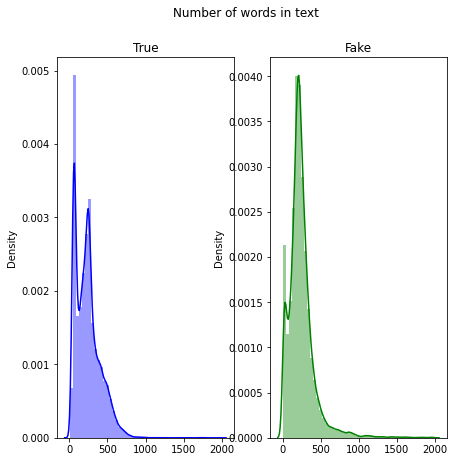

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


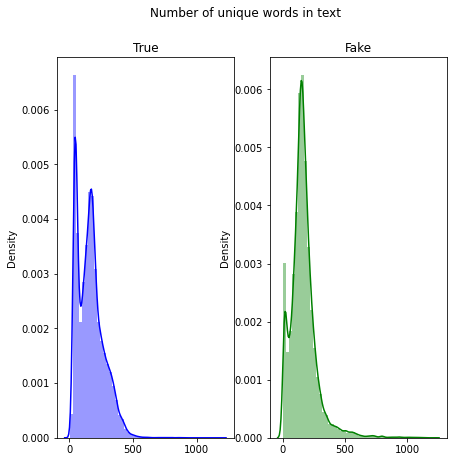

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


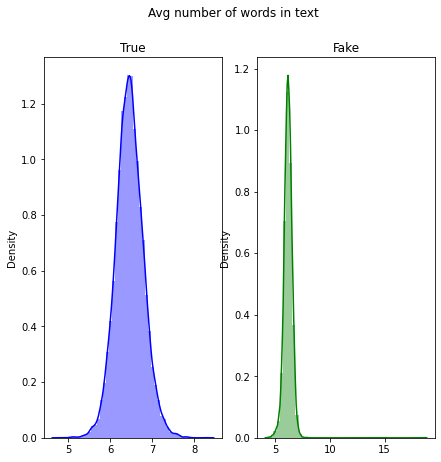

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate

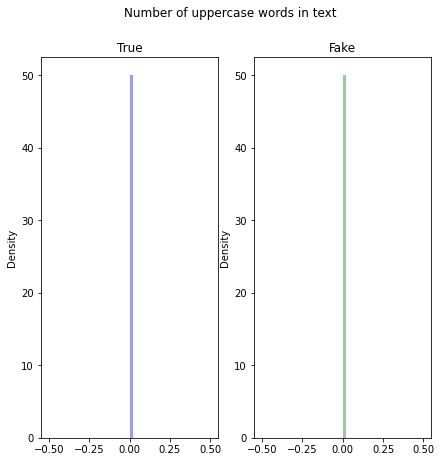

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


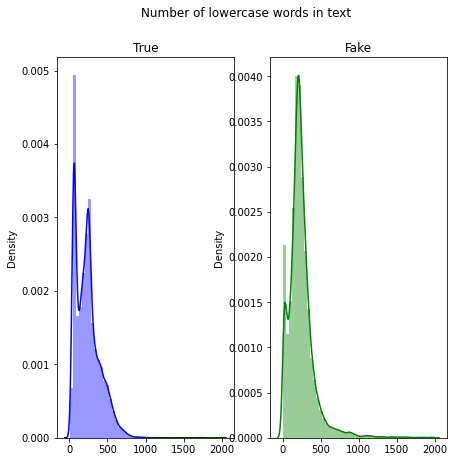

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


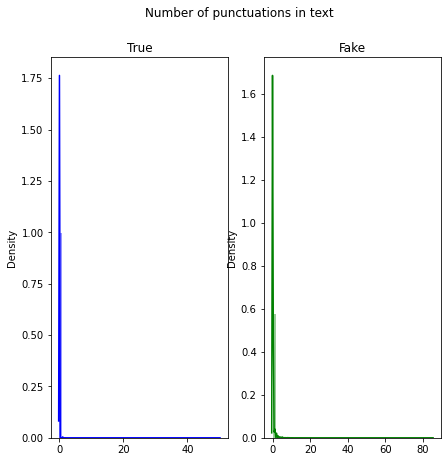

In [40]:
cols = ['number_of_words','number_of_unique_words','avg_number_of_words','number_of_uppercase_words','number_of_lowercase_words','number_of_punctuations']

def DistributionPlot(column):

    x1 = subset[subset['label'] == 'True'][column]
    x2 = subset[subset['label'] == 'Fake'][column]
    
    header = ' '.join(column.split('_')).capitalize() + ' in text'
    
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (7,7))
    sns.distplot(x1 , color = "blue", ax = ax1, axlabel = '')

    ax1.set_title('True')
    sns.distplot(x2 , color = "green", ax = ax2, axlabel = '')

    ax2.set_title('Fake')
    fig.suptitle(header)
    plt.show()

DistributionPlot('number_of_words')
DistributionPlot('number_of_unique_words')
DistributionPlot('avg_number_of_words')
DistributionPlot('number_of_uppercase_words')
DistributionPlot('number_of_lowercase_words')
DistributionPlot('number_of_punctuations')

Παρατηρώ ότι τα fake news χρησιμοποιούνε πιο πολλά κεφαλαία, πιο πολλά σημεία στίξης,αλλά λιγότερες διαφορετικές λέξεις σε σχέση με τα true news.

#3:  Δημιουργία συνόλου εκμάθησης και δοκιμής

In [41]:
def Get_Sentences(series):

    output = []

    for i in series:
        output.append(i.split())
    
    return output
        
# Each text is now represented as list of its words
sent = Get_Sentences(data['final_text'])
sent[0]

['donald',
 'trump',
 'sends',
 'embarrassing',
 'new',
 'year',
 'eve',
 'message',
 'disturbing',
 'donald',
 'trump',
 'wish',
 'americans',
 'happy',
 'new',
 'year',
 'leave',
 'instead',
 'give',
 'shout',
 'enemies',
 'haters',
 'dishonest',
 'fake',
 'news',
 'media',
 'former',
 'reality',
 'show',
 'star',
 'one',
 'job',
 'country',
 'rapidly',
 'grows',
 'stronger',
 'smarter',
 'want',
 'wish',
 'friends',
 'supporters',
 'enemies',
 'haters',
 'even',
 'dishonest',
 'fake',
 'news',
 'media',
 'happy',
 'healthy',
 'new',
 'year',
 'president',
 'angry',
 'pants',
 'tweeted',
 '2018',
 'great',
 'year',
 'america',
 'country',
 'rapidly',
 'grows',
 'stronger',
 'smarter',
 'want',
 'wish',
 'friends',
 'supporters',
 'enemies',
 'haters',
 'even',
 'dishonest',
 'fake',
 'news',
 'media',
 'happy',
 'healthy',
 'new',
 'year',
 '2018',
 'great',
 'year',
 'america',
 'donald',
 'trump',
 'realdonaldtrump',
 'december',
 '31',
 '2017trump',
 'tweet',
 'went',
 'welll',
 '

In [43]:
# Train the Word2Vec model on our sentences using a dimensional size of 100, window of 5, and a min_count of 5 (these are default).
wv_model = gensim.models.Word2Vec(sentences = sent, size = 100, window = 5, min_count = 5)
print('%s words are now represented as a vector of size 100' % len(wv_model.wv.vocab))

def GetSimilarWords(word):
    word = word.lower()
    return print('Most similar words to %s are: \n%s' %(word,wv_model.wv.most_similar(word)))

GetSimilarWords('read')
GetSimilarWords('woman')
GetSimilarWords('facebook')

46211 words are now represented as a vector of size 100
Most similar words to read are: 
[('reading', 0.6560288667678833), ('reads', 0.6459441184997559), ('write', 0.6173866987228394), ('written', 0.5992113351821899), ('explaining', 0.5757557153701782), ('via', 0.5580096244812012), ('publish', 0.5566690564155579), ('courtesy', 0.49617451429367065), ('corrected', 0.4952148497104645), ('wrote', 0.49039095640182495)]
Most similar words to woman are: 
[('man', 0.8131453990936279), ('girl', 0.746706485748291), ('person', 0.6645224690437317), ('victim', 0.6354830265045166), ('child', 0.625433087348938), ('boy', 0.6179454326629639), ('mother', 0.577867865562439), ('women', 0.5715675354003906), ('daughter', 0.5713748931884766), ('boys', 0.5619144439697266)]
Most similar words to facebook are: 
[('reddit', 0.6427856087684631), ('instagram', 0.6317027807235718), ('google', 0.5952965617179871), ('fb', 0.5654352903366089), ('blog', 0.5599040985107422), ('huffington', 0.559237539768219), ('online',

Ας δημιουργήσουμε το μοντέλο

In [45]:
# Keras tools for creating our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Transform each word to a number in our corpus to be fed into the NN
our_tokenizer = Tokenizer()
our_tokenizer.fit_on_texts(sent)
tokenized_sentences = our_tokenizer.texts_to_sequences(sent)

tokenized_sentences = pad_sequences(tokenized_sentences, maxlen = 800)
target = data['label'].values
target = [1 if x == 'True' else 0 for x in target]

In [47]:
# Create our training and testing split
X_train, X_test, y_train, y_test = train_test_split(tokenized_sentences, target, test_size = 0.20, random_state = 0)

vocabulary_length = len(our_tokenizer.word_index) + 1

def GetEmbeddingMatrix(dictionary_of_words, word2vec_model, vocabulary_length, embedding_size = 100):

    # Define an empty matrix
    embedding_matrix = np.zeros((vocabulary_length, embedding_size))

    # For each word store the vector in the matrix using the position of i
    for word, i in dictionary_of_words.items():
        if not word2vec_model.wv.__contains__(word):
            continue
        else:
            embedding_matrix[i] = word2vec_model.wv.__getitem__(word)
    return embedding_matrix

embedding_matrix = GetEmbeddingMatrix(our_tokenizer.word_index, wv_model, vocabulary_length)

In [48]:
model = Sequential()
embedding_layer = Embedding(vocabulary_length, output_dim = 100, weights = [embedding_matrix], input_length = 800, trainable = False)

model.add(embedding_layer)
model.add(LSTM(units = 128))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

Μοντέλο

In [55]:

history = model.fit(np.array(X_train), np.array(y_train), validation_split = 0.3, epochs = 10)

Epoch 1/10
786/786 [==============================] - 580s 715ms/step - loss: 0.1539 - acc: 0.9438 - val_loss: 0.1021 - val_acc: 0.9726
Epoch 2/10
786/786 [==============================] - 562s 715ms/step - loss: 0.0540 - acc: 0.9823 - val_loss: 0.0595 - val_acc: 0.9807
Epoch 3/10
786/786 [==============================] - 561s 714ms/step - loss: 0.0260 - acc: 0.9932 - val_loss: 0.0206 - val_acc: 0.9959
Epoch 4/10
786/786 [==============================] - 561s 714ms/step - loss: 0.0070 - acc: 0.9982 - val_loss: 0.0169 - val_acc: 0.9954
Epoch 5/10
786/786 [==============================] - 561s 714ms/step - loss: 0.0121 - acc: 0.9972 - val_loss: 0.0185 - val_acc: 0.9968
Epoch 6/10
786/786 [==============================] - 561s 714ms/step - loss: 0.0071 - acc: 0.9986 - val_loss: 0.0148 - val_acc: 0.9974
Epoch 7/10
786/786 [==============================] - 561s 714ms/step - loss: 0.0023 - acc: 0.9993 - val_loss: 0.0146 - val_acc: 0.9974
Epoch 8/10
786/786 [============================

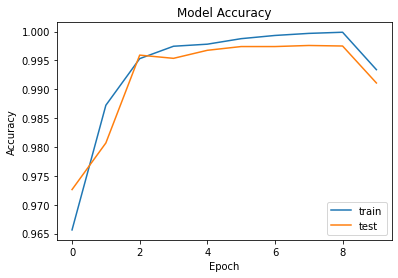

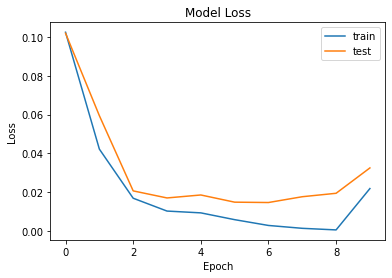

In [58]:
#Model Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc = 'lower right')
plt.show()

#Model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc = 'upper right')
plt.show()

Για να υπολογίσουμε accuracy, αρχίζουμε με ένα μικρό epochs=2 και σταδιακά το αυξάνουμε .

In [60]:
predictions = model.predict(X_test)
# For predictions with probability above 50% we will take as True and the rest as Fake
predictions = (predictions >= 0.5).astype(int)

confusion_report = confusion_matrix(y_test,predictions)
tn, fp, fn, tp = confusion_report.ravel()

print('True positive (Actual and predicted True): %s' % tp)
print('True negative (Actual and predicted False): %s' % tn)
print('False positive (Predicted True but actually False): %s' % fp)
print('False negative (Predicted False but actually True): %s' % fn)

True positive (Actual and predicted True): 4224
True negative (Actual and predicted False): 4686
False positive (Predicted True but actually False): 30
False negative (Predicted False but actually True): 38


In [62]:
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

FalseOmissionRate = fn / (fn + tn)
Precision = tp / (tp + fp)


print('True positive rate is proportion of correctly classified results as True (Recall): %s' %round(tpr,4))
print('\nTrue negative rate is proportion of correctly classified results as False (Specificity): %s' %round(tnr,4))
print('\nFalse positive rate is proportion of incorrectly classified results as True: %s' %round(fpr,4))
print('\nFalse negative rate is proportion of incorrectly classified results as False: %s' %round(fnr,4))
print('\nPrecision is proportion of correctly classified True results from all predicted True results: %s' %round(precision,4))
print('\nFalse ommision rate is proportion of incorrectly classified False results from all predicted False results: %s' %round(FalseOmissionRate,4))

True positive rate is proportion of correctly classified results as True (Recall): 0.9911

True negative rate is proportion of correctly classified results as False (Specificity): 0.9936

False positive rate is proportion of incorrectly classified results as True: 0.0064

False negative rate is proportion of incorrectly classified results as False: 0.0089

Precision is proportion of correctly classified True results from all predicted True results: 0.9929

False ommision rate is proportion of incorrectly classified False results from all predicted False results: 0.008


Θα 'λεγε κανείς ότι έχουμε υψηλή ακρίβεια καθώς έχουμε υψηλή ανάκληση σε συνδυασμό με χαμηλό false positive/negative ποσοστό .